# Notebook to fine-tune Segment Anything (SAM)
This notebook goes together with this [medium post](https://medium.com/p/34514ee811bb/edit). The article provides a high-level overview of the concepts of how to fine-tune SAM. Read it first (if you haven't already), it will help to understand the colab. The structure will be:
- 00 Installation and define Variables
- 01 SAM without fine-tuning
- 02 Define functions and classes for fine-tuning
- 03 Plan for fine-tuning
- 04 Define models and classes for fine-tuning
- 05 Wrap up



## 00 Installing packages and defining variables
Start with the boring part. The code in this section will import everything you need and define the global variables. If you use your data, we also define this here, but I'll also provide a small dataset. So in summary:
- install packages
- define variables
- adjust for your data

Let's go!

## Acknowledgments:

I thank:
- [Luca Medeiros](https://github.com/luca-medeiros/lightning-sam/tree/main/lightning_sam) whos code (even I could not get to run it on our cluster) helped me immensly in understanding SAM.
- Sabine Lorius for labeling the images
- Dr. Daniel Freund for providing the images


### 00 Install segment anything

In [38]:
# !pip install segment_anything
import sys
sys.path.append('MobileSAM')


### Import packages

In [39]:


# from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
from mobile_sam import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import glob
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

import json
import toml
import os
import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms
from pycocotools.coco import COCO
# from segment_anything import sam_model_registry
from mobile_sam.utils.transforms import ResizeLongestSide
from torch.utils.data import DataLoader, Dataset
import logging
# import sys
import torch
import torch.nn as nn
import torch.nn.functional as F


### Define variables
In this section, we'll define global variables. Whenever I put TODO as a comment, you might want to change my path to your own data, or adjust model parameters, etc.

To use data on Google Drive, we first need to mount Google Drive like so:

In [40]:

# from google.colab import drive
# drive.mount('/content/drive')


In [41]:

from torch.types import Device
#data
global train
global test
global annot

# TODO: Put your path here !!!!
# train = "data/leftImg8bit/val/frankfurt/"
train = "data/train2017"
# test = "data/leftImg8bit/val/frankfurt/"
test = "data/val2017"
annot = "instances_val2017.json"
# train = "/content/drive/MyDrive/ColabNotebooks/finetunesam/test"
# test = "/content/drive/MyDrive/ColabNotebooks/finetunesam/train"
# annot = "annotations.json"
#model
global batch_size
global epochs
global lr
global weight_decay
global DEVICE

# TODOD adjust, if needed!!!!
batch_size = 2
epochs = 10
lr = 0.0001
weight_decay = 0.0005
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# loss
global alpha
global gamma
alpha = 0.8
gamma = 2


cuda


### Take a first look at the data

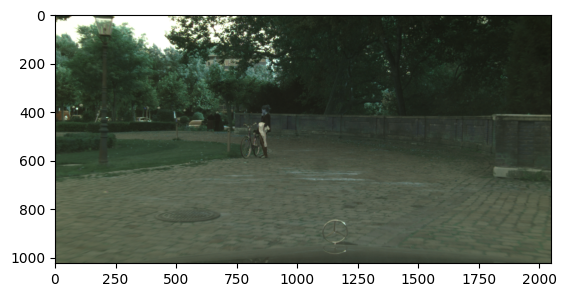

In [42]:
from pathlib import Path

# coco_path = Path.cwd() / "coco" / "coco"

# coco_images = coco_path / "images"
# coco_train = coco_images / "train2017"
# coco_val = coco_images / "val2017"
# coco_test = coco_images / "test2017"

# coco_ann = coco_path / "annotations"
# coco_train_ann = coco_ann / "instances_train2017.json"
# coco_val_ann = coco_ann / "instances_val2017.json"

coco_path = Path.cwd() / "coco" / "cityscapes"

# coco_images = coco_path / "leftImg8bit"
coco_train = coco_path
coco_val = coco_path
coco_test = coco_path

coco_ann = coco_path / "annotations"
coco_train_ann = coco_ann / "instancesonly_filtered_gtFine_train.json"
coco_val_ann = coco_ann / "instancesonly_filtered_gtFine_val.json"

# TODO add your path
# sample_path = next(image for city in coco_val.iterdir() for image in city.iterdir())
sample_path = next(coco_val.glob("leftImg8bit/**/*.png"))
# print(sample_path)
sample_img = cv2.imread(str(sample_path))
plt.imshow(sample_img)


## 01 Segment image with SAM
Now we'll quickly use the wrapper classes from SAM, to segment our images, and we'll see why we need to fine-tune the model directly later. If you have not done so, you need to download the sam model see [here](https://github.com/facebookresearch/segment-anything/tree/main#model-checkpoints).

Segment anything provides a class "SamAutomaticMaskGenerator". This class generates all masks for the whole image. However, it returns each mask separately, that's why we need a helper function to combine all masks in one image.

In [43]:

from typing import List, Dict, Any
def build_totalmask(pred: List[Dict[str, Any]]) -> np.ndarray:
    """Builds a total mask from a list of segmentations
    ARGS:
        pred (list): list of dicts with keys 'segmentation' and others
    RETURNS:
        total_mask (np.ndarray): total mask

    """

    total_mask = np.zeros(pred[0]['segmentation'].shape, dtype=np.uint8)
    for seg in pred:
        total_mask += seg['segmentation']
    # use cv2 to make image black and white
    _, total_mask = cv2.threshold(total_mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)


    return total_mask


In [44]:
sam = sam_model_registry["vit_t"](checkpoint="MobileSAM/weights/mobile_sam.pt") #TODO your path here
mask_generator = SamAutomaticMaskGenerator(sam)


In [45]:
sam.to(DEVICE)


Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
 

In [46]:
# generate masks and investigate object
# hint: run this with GPU support
masks = mask_generator.generate(sample_img)
print(type(masks))


<class 'list'>


In [47]:
print(len(masks))
print(type(masks[0]))
print(f'keys of dict: {masks[0].keys()}')


31
<class 'dict'>
keys of dict: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [48]:
print(f"Shape of masks: {masks[0]['segmentation'].shape}")
print('Value counts in segmentation of first mask:')
print(np.unique(masks[0]['segmentation'], return_counts=True))


Shape of masks: (1024, 2048)
Value counts in segmentation of first mask:
(array([False,  True]), array([1544200,  552952]))


In [49]:
total_mask = build_totalmask(masks)


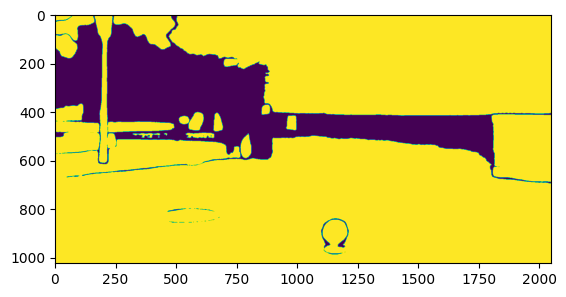

In [50]:
plt.imshow(total_mask)


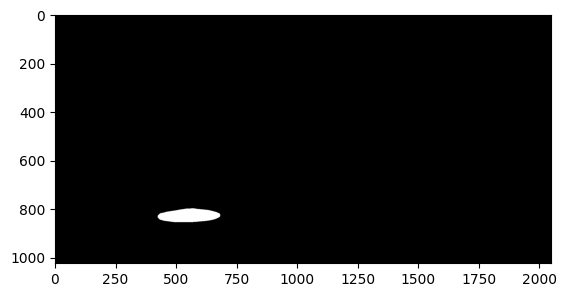

In [51]:
plt.imshow(masks[5]['segmentation'], cmap='gray')


When you use the web app of SAM, you might notice, that you need to provide a prompt (i.e. point with your mouse where your object is) to get a result. The mask_generator does this for you, by providing a grid of points over the whole image and creating a mask for each point and then later removing duplicated and low-quality masks. See the point grid below:

KeyboardInterrupt: 

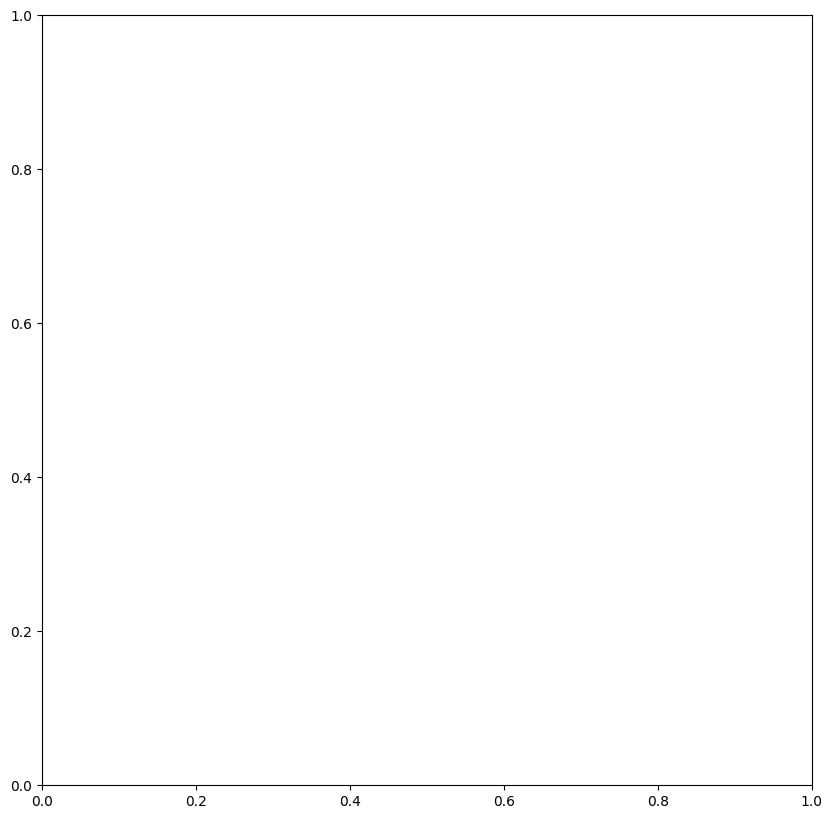

In [52]:
points = mask_generator.point_grids[0]
# plot image and lay points on it
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(sample_img)
h, w, _c = sample_img.shape
ax.scatter(x=points[:, 0] * w, y=points[:, 1] * h, c="r", s=10)
ax.set_axis_off()
plt.show()


### Summary Segment Anything out of the box:
- SAM takes any image and preprocess it for you
- The SamAutomaticMaskGenerator class infers all masks of the image for you.
- The output of the mask generator is a list of dictionaries, where each list item represents a mask.
- The mask generator uses a grid of points as prompts and generates masks for each point.[see here](https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py)
- The SamAutomaticMaskGenerator cannot be fine-tuned, because Facebook coded it with no_grad, and the output gets postprocessed.
- So we will need the sam model directly to fine-tune. Therefore we'll define a few helper classes in the next section:

## 02 Define models and classes for fine-tuning
To make our life more easy, we'll define some functions and classes here:
- Class COCODataset: helper to read in the annotations.json in coco format
- class ResizeAndPad: helper to preprocess images to fit the expected size from SAM
- load_datasets: function to get annotated COCO images into PyTorch dataloader

You don't need to change anything here, you can just use the classes and functions later on.
Feel free to skim through the code to gain better comprehension.

In [ ]:
# %pip install -q cityscapesscripts


In [ ]:
# %pip install git+https://github.com/cocodataset/panopticapi.git


In [ ]:
from multiprocessing import cpu_count

class COCODataset(Dataset):
    """
    A PyTorch Dataset to load data from a json file in COCO format.

    ...
    Attributes
    ----------
    root_dir : str
        the root directory containing the images and annotations
    annotation_file : str
        name of the json file containing the annotations (in root_dir)
    transform : callable
        a function/transform to apply to each image

    Methods
    -------
    __getitem__(idx)
        returns the image, image path, and masks for the given index
    buid_total_mask(masks)
        combines the masks into a single mask
    """


    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())

        # Filter out image_ids without any annotations
        self.image_ids = [image_id for image_id in self.image_ids if len(self.coco.getAnnIds(imgIds=image_id)) > 0]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = self.root_dir / Path(image_info['file_name'])
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)
        bboxes = []
        masks = []

        for ann in anns:
            x, y, w, h = ann['bbox']
            bboxes.append([x, y, x + w, y + h])
            mask = self.coco.annToMask(ann)
            masks.append(mask)

        if self.transform:
            image, masks, bboxes = self.transform(image, masks, np.array(bboxes))

        bboxes = np.stack(bboxes, axis=0)
        masks = np.stack(masks, axis=0)
        return image, str(image_path), torch.tensor(masks).float()

    def get_totalmask(self, masks):
        """get all masks in to one image
        ARGS:
            masks (List[Tensor]): list of masks
        RETURNS:
            total_gt (Tensor): all masks in one image

        """
        total_gt = torch.zeros_like(masks[0][0,:,:])
        for k in range(len(masks[0])):
            total_gt += masks[0][k,:,:]
        return total_gt



class ResizeAndPad:
    """
    Resize and pad images and masks to a target size.

    ...
    Attributes
    ----------
    target_size : int
        the target size of the image
    transform : ResizeLongestSide
        a transform to resize the image and masks
    """

    def __init__(self, target_size):
        self.target_size = target_size
        self.transform = ResizeLongestSide(target_size)
        self.to_tensor = transforms.ToTensor()

    def __call__(self, image, masks, bboxes):
        # Resize image and masks
        og_h, og_w, _ = image.shape
        image = self.transform.apply_image(image)
        masks = [torch.tensor(self.transform.apply_image(mask)) for mask in masks]
        image = self.to_tensor(image)

        # Pad image and masks to form a square
        _, h, w = image.shape
        max_dim = max(w, h)
        pad_w = (max_dim - w) // 2
        pad_h = (max_dim - h) // 2

        padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
        image = transforms.Pad(padding)(image)
        masks = [transforms.Pad(padding)(mask) for mask in masks]

        # Adjust bounding boxes
        bboxes = self.transform.apply_boxes(bboxes, (og_h, og_w))
        bboxes = [[bbox[0] + pad_w, bbox[1] + pad_h, bbox[2] + pad_w, bbox[3] + pad_h] for bbox in bboxes]

        return image, masks, bboxes


def load_datasets(
        img_size=1024,
        # *,
        # train_path="data/train2017",
        # val_path="data/val2017",
        # annot_train="instances_train2017.json",
        # annot_val="instances_val2017.json",
    ):
    """ load the training and validation datasets in PyTorch DataLoader objects
    ARGS:
        img_size (Tuple(int, int)): image size
    RETURNS:
        train_dataloader (DataLoader): training dataset
        val_dataloader (DataLoader): validation dataset

    """
    transform = ResizeAndPad(img_size)
    traindata = COCODataset(root_dir=coco_train,
                        annotation_file=coco_train_ann,
                        transform=transform)
    valdata = COCODataset(root_dir=coco_val,
                      annotation_file=coco_val_ann,
                      transform=transform)
    # traindata = torch.utils.data.Subset(traindata, range(len(traindata) // 100))
    # valdata = torch.utils.data.Subset(valdata, range(len(valdata) // 100))
    train_dataloader = DataLoader(traindata,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=cpu_count())
    val_dataloader = DataLoader(valdata,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=cpu_count())
    return train_dataloader, val_dataloader


In [ ]:
trainloader, validloader = load_datasets(1024)
sample_img = trainloader.dataset[0][0]
sample_mask = trainloader.dataset[0][2]


loading annotations into memory...
Done (t=6.32s)
creating index...
index created!
loading annotations into memory...
Done (t=0.88s)
creating index...
index created!


In [ ]:
print(f'shape of sample_img: {sample_img.shape}')
print(f'shape fo sample_mask: {sample_mask.shape}')


shape of sample_img: torch.Size([3, 1024, 1024])
shape fo sample_mask: torch.Size([9, 1024, 1024])


### Summary functions and classes:
Now we have transformed our images and coco annotations to torch tensors, that we can use for training. For training (fine-tuning SAM) we need to define a Neural net with PyTorch first, we do this in the next class. It's pretty well documented, so I'll leave you with the code:

In [ ]:
import torch.nn as nn
class ModelSimple(nn.Module):
    """
    Wrapper for the sam model to to fine-tune the model on a new dataset

    ...
    Attributes:
    -----------
    freeze_encoder (bool): freeze the encoder weights
    freeze_decoder (bool): freeze the decoder weights
    freeze_prompt_encoder (bool): freeze the prompt encoder weights
    transform (ResizeLongestSide): resize the images to the model input size

    Methods:
    --------
    setup(): load the model and freeze the weights
    forward(images, points): forward pass of the model, returns the masks and iou_predictions
    """

    def __init__(self, freeze_encoder=True, freeze_decoder=False, freeze_prompt_encoder=True):
        super().__init__()
        self.freeze_encoder = freeze_encoder
        self.freeze_decoder = freeze_decoder
        self.freeze_prompt_encoder = freeze_prompt_encoder
        # we need this to make the input image size compatible with the model
        self.transform = ResizeLongestSide(1024) #This is 1024, because sam was trained on 1024x1024 images

    def setup(self):
        # self.model = sam
        self.model = sam_model_registry["vit_t"](checkpoint="MobileSAM/weights/mobile_sam.pt") #TODO your path here
        # mask_generator = SamAutomaticMaskGenerator(sam)
        # to speed up training time, we normally freeze the encoder and decoder
        if self.freeze_encoder:
            for param in self.model.image_encoder.parameters():
                param.requires_grad = False
        if self.freeze_prompt_encoder:
            for param in self.model.prompt_encoder.parameters():
                param.requires_grad = False
        if self.freeze_decoder:
            for param in self.model.mask_decoder.parameters():
                param.requires_grad = False
        self.transfrom = ResizeLongestSide(self.model.image_encoder.img_size)
    def forward(self, images):
        _, _, H, W = images.shape # batch, channel, height, width
        image_embeddings = self.model.image_encoder(images) # shape: (1, 256, 64, 64)
        # get prompt embeddings without acutally any prompts (uninformative)
        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points=None,
            boxes=None,
            masks=None,
        )

        # get low resolution masks and iou predictions
        # mulitmask_output=False means that we only get one mask per image,
        # otherwise we would get three masks per image
        low_res_masks, iou_predictions = self.model.mask_decoder(
            image_embeddings=image_embeddings,
            image_pe=self.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings, # sparse_embeddings shape: (1, 0, 256)
            dense_prompt_embeddings=dense_embeddings, # dense_embeddings shape: (1, 256, 256)
            multimask_output=False,
        )
        # postprocess the masks to get the final masks and resize them to the original image size
        masks = F.interpolate(
            low_res_masks, # shape: (1, 1, 256, 256)
            (H, W),
            mode="bilinear",
            align_corners=False,
        )
        # shape masks after interpolate: torch.Size([1, 1, 1024, 1024])
        return masks, iou_predictions


In [ ]:

model = ModelSimple()
model.setup()
img_size = model.model.image_encoder.img_size
print(img_size)


1024


## 03 Plan for fine-tuning
When you've read the code in the cell above, this should be clear. We'll use the SAM model directly to output a 1024,1024 mask. This will be a probability map of the location of masks. As you see in line 45 above we don't provide any prompts. We do this to save us work with the postprocessing. To get all our masks for the image, we'll just put our ground truth masks (all masks for one image) in the loss function. So that we'll force the model to output high values for areas with masks.

Now alt that's left is defining the loss functions and the training loop. For the loss function, we use the same as the authors of the SAM paper:

Quote from Sam Paper
```
Losses. We supervise mask prediction with a linear combination of focal loss [65] and dice loss [73] in a 20:1 ratio of
focal loss to dice loss, following [20, 14]. Unlike [20, 14],
we observe that auxiliary deep supervision after each decoder layer is unhelpful. The IoU prediction head is trained
with mean-square-error loss between the IoU prediction and
the predicted mask's IoU with the ground truth mask. It is
added to the mask loss with a constant scaling factor of 1.0.
```
We won't train the IoU prediction head in our case.

## 04 Models, classes functions for fine-tuning
To make our code more clear, we'll define the following classes and functions to fine-tune SAM:
- get_totalmask (function): combines all single object masks into one mask per image
- FocalLoss (class): to calculate Focalloss
- DiceLoss (class): to calculate Diceloss
- criterion (function): combines Dice- and Focalloss. This is our final loss function
- train_one_epoch(function): calculates loss for each batch
- train (function) calls train_one_epoch for each epoch and calculates validation loss

In [ ]:
%pip install -q tensorboard


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from tqdm.autonotebook import trange, tqdm
from torch.utils.tensorboard import SummaryWriter

def get_totalmask(masks):
    """get all masks in to one image
    ARGS:
        masks (torch.Tensor): shape: (N, H, W) where N is the number of masks
                              masks H,W is usually 1024,1024
    RETURNS:
        total_gt (torch.Tensor): all masks in one image

    """
    total_gt = torch.zeros_like(masks[0,:,:])
    for k in range(len(masks)):
        total_gt += masks[k,:,:]
    return total_gt



class FocalLoss(nn.Module):
    """ Computes the Focal loss. """

    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets):

        inputs = inputs.flatten(0,2)
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1 - BCE_EXP)**gamma * BCE

        return focal_loss


class DiceLoss(nn.Module):
    """ Computes the Dice loss. """

    def __init__(self):
        super().__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = F.sigmoid(inputs)
        inputs = inputs.flatten(0,2)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / \
            (inputs.sum() + targets.sum() + smooth)
        return 1 - dice



def criterion(x, y):
    """ Combined dice and focal loss.
    ARGS:
        x: (torch.Tensor) the model output
        y: (torch.Tensor) the target
    RETURNS:
        (torch.Tensor) the combined loss

    """
    focal, dice = FocalLoss(), DiceLoss()
    y = y.to(DEVICE)
    x = x.to(DEVICE)
    return 20 * focal(x, y) + dice(x, y)


def train_one_epoch(model, trainloader, optimizer, epoch_idx, tb_writer=None):
    """ Runs forward and backward pass for one epoch and returns the average
    batch loss for the epoch.
    ARGS:
        model: (nn.Module) the model to train
        trainloader: (torch.utils.data.DataLoader) the dataloader for training
        optimizer: (torch.optim.Optimizer) the optimizer to use for training
        epoch_idx: (int) the index of the current epoch
        tb_writer: (torch.utils.tensorboard.writer.SummaryWriter) the tensorboard writer
    RETURNS:
        last_loss: (float) the average batch loss for the epoch

    """
    running_loss = 0.
    for i, (image, path, masks) in enumerate(tqdm(trainloader)):
        # print(f'train1epch image: {image}')
        # print(f'train1epch path: {path}')
        # continue
        image = image.to(DEVICE)
        optimizer.zero_grad()
        pred, _ = model(image)
        # print(f'pred shape: {pred.shape}')
        masks = masks[0].to(DEVICE)
        total_mask = get_totalmask(masks)
        pred = pred
        loss = criterion(pred, total_mask)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    i = len(trainloader)
    last_loss = running_loss / i
    print(f'batch_loss: {last_loss}')
    tb_x = epoch_idx * len(trainloader) + i + 1
    if tb_writer:
        tb_writer.add_scalar('Loss/train', last_loss, tb_x)
    running_loss = 0.
    return last_loss


def trainfun(model, trainloader, validloader):
    """ Trains the model for the given number of epochs."""
    # bestmodel_path = ""
    model.to(DEVICE)
    # img_size = model.model.image_encoder.img_size
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_valid_loss = float('inf')
    writer = SummaryWriter()

    for epch in trange(epochs):
        running_vloss = 0.
        model.train(True)
        avg_batchloss = train_one_epoch(
            model, trainloader, optimizer, epch,
            writer)
        model.eval()
        with torch.no_grad():
            for images, path, masks in validloader:
                images = images.to(DEVICE)
                masks = masks[0].to(DEVICE)
                total_mask = get_totalmask(masks)
                total_mask = total_mask.to(DEVICE)
                model.eval()
                preds, iou = model(images)
                preds = preds.to(DEVICE)
                vloss = criterion(preds, total_mask)
                running_vloss += vloss.item()
        print(f'epoch: {epch}, validloss: {running_vloss}')
        # save model
        print(f'epoch: {epch}, validloss: {running_vloss}')
        if running_vloss < best_valid_loss:
            best_model = model
            best_valid_loss = running_vloss
            torch.save(best_model.state_dict(), 'model_final.pth')
        print(f'best valid loss: {best_valid_loss}')
    return model

# next add train function for prompting model with points (ModelAll)
# next unrelated find out how to get tensor output of masks form SamAutomaticMaskGenerator


In [ ]:
trainloader, validloader = load_datasets(img_size=img_size)


loading annotations into memory...
Done (t=5.74s)
creating index...
index created!
loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


## 05 Wrap up and next steps

Training the model on Colab might run out of RAM, when you don't have premium (at least it did for me) I've trained the model on an HPC cluster. I'll leave you with the code to train the model and also some functions to visualize and evaluate.

### Train:



In [ ]:
model = ModelSimple()
model.setup()


In [37]:
trainfun(model, trainloader, validloader)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2965 [00:00<?, ?it/s]

batch_loss: 2.4371826174739644
epoch: 0, validloss: 527.0247495174408
epoch: 0, validloss: 527.0247495174408
best valid loss: 527.0247495174408


  0%|          | 0/2965 [00:00<?, ?it/s]

batch_loss: 1.0858203049855932
epoch: 1, validloss: 527.581313252449
epoch: 1, validloss: 527.581313252449
best valid loss: 527.0247495174408


  0%|          | 0/2965 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Predict trained model

Here I assume that you have fine-tuned SAM with the code above and the fine-tuned model is saved as model_final.pth

In [ ]:
def show_anns(anns, ax):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        # print(color_mask.any())
        img[m] = color_mask
    ax.imshow(img)


In [ ]:
# predict trainied model
model_trained = model
with torch.no_grad():
    model_trained.load_state_dict(torch.load('model_final.pth', map_location=torch.device('cpu')))
    model_trained.eval()
    img_size = model_trained.model.image_encoder.img_size
    print(f'img_size: {img_size}')
    print(f'img_size: {model_trained.model.image_encoder.img_size}')
    # todo your code here
    # mask_generator = samautomaticmaskgenerator(sam.to(device))
    for _, (img, _, gt_masks) in zip(range(1), validloader.dataset):
        gt_masks = [dict(segmentation=m, area=m.sum()) for m in gt_masks.bool()]
        img = img.permute(1, 2, 0).mul(255).numpy().astype(np.uint8)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
        ax1.imshow(img)
        ax2.imshow(img)

        show_anns(gt_masks, ax=ax1)

        annotations = mask_generator.generate(img)
        show_anns(annotations, ax=ax2)

        ax1.axis('off')
        ax2.axis('off')

        plt.show()


img_size: 1024
img_size: 1024


KeyboardInterrupt: 